In [67]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import joblib
import pandas as pd
import numpy as np

In [68]:
df = pd.read_csv('../data/processed/sample_feature_engineered.csv')
df.head()

,duration_seconds,brightness_score,text_to_image_ratio,logo_size_ratio,has_human_face,face_count,sentiment_score,word_count,music_tempo,speech_pace,...,color_palette_primary_R,color_palette_primary_G,color_palette_primary_B,platform_encoded,ad_type_encoded,industry_encoded,campaign_objective_encoded,target_audience_gender_encoded,aspect_ratio_encoded,cta_type_encoded
0,0,68,0.25,0.08,1,1,0.65,18,0.0,0.0,...,245,40,36,1,1,17,3,1,1,17
1,28,72,0.15,0.05,1,1,0.82,12,115.0,145.0,...,200,180,255,2,3,2,2,0,4,11
2,0,55,0.35,0.12,1,2,0.28,35,0.0,0.0,...,30,50,120,0,1,1,4,0,0,14
3,15,48,0.08,0.06,1,3,0.67,22,95.0,135.0,...,20,20,20,3,3,7,1,0,0,21
4,0,75,0.18,0.07,0,0,0.42,14,0.0,0.0,...,255,255,255,1,0,4,3,0,1,17


In [69]:
df.columns
other_targets = ['impressions', 'clicks', 'ctr', 'conversions', 'conversion_rate'] # I'll work only with ROI as my target for now
df = df.drop(columns=other_targets)

In [70]:
df.columns

Index(['duration_seconds', 'brightness_score', 'text_to_image_ratio',
       'logo_size_ratio', 'has_human_face', 'face_count', 'sentiment_score',
       'word_count', 'music_tempo', 'speech_pace', 'roi',
       'color_palette_primary_R', 'color_palette_primary_G',
       'color_palette_primary_B', 'platform_encoded', 'ad_type_encoded',
       'industry_encoded', 'campaign_objective_encoded',
       'target_audience_gender_encoded', 'aspect_ratio_encoded',
       'cta_type_encoded'],
      dtype='object')

In [71]:
X = df.drop(columns=['roi'])
y = df['roi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 20), (10, 20), (40,), (10,))

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Work with a unified model

In [74]:
xgb_model = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

xgb_model.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [75]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [76]:
def evaluate_model(model, X_test, y_test):
    preds = cross_val_predict(model, X_test, y_test, cv=kf)
    
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)

    return preds, {"R²": r2, "MAE": mae, "RMSE": rmse}

xgb_preds, xgb_metrics = evaluate_model(xgb_model, X_test_scaled, y_test)
rf_preds, rf_metrics = evaluate_model(rf, X_test_scaled, y_test)

In [77]:
xgb_preds, xgb_metrics

(array([4.7994366, 6.4697604, 3.9610534, 1.8024633, 6.8801937, 2.4273837,
        5.2413526, 5.271068 , 4.6588326, 4.3444147], dtype=float32),
 {'R²': 0.12065143082968144,
  'MAE': 1.4266426277160644,
  'RMSE': 1.7117468759522882})

In [78]:
rf_preds, rf_metrics

(array([4.676, 5.438, 3.085, 3.015, 5.958, 3.113, 5.565, 5.524, 3.248,
        4.762]),
 {'R²': 0.49715938897392076,
  'MAE': 0.8581999999999983,
  'RMSE': 1.294416934376246})

- XGB perfoms better than RF

In [79]:
def roi_to_score(predicted_roi, min_roi, max_roi):
    score = 1 + 99 * ((predicted_roi - min_roi) / (max_roi - min_roi))
    return np.clip(np.round(score), 1, 100)

min_roi, max_roi = y.min(), y.max()
xgb_score = roi_to_score(xgb_preds, min_roi, max_roi)
rf_score = roi_to_score(rf_preds, min_roi, max_roi)

In [80]:
xgb_score

array([38., 51., 32., 15., 54., 20., 42., 42., 37., 35.], dtype=float32)

In [81]:
rf_score

array([37., 43., 25., 24., 47., 25., 44., 44., 26., 38.])

In [82]:
results_df = pd.DataFrame({
    "True ROI": y_test,
    "XGB ROI": xgb_preds,
    "XGB Score (1-100)": xgb_score,
    "RF ROI": rf_preds,
    "RF Score (1-100)": rf_score
})

In [83]:
n_bootstraps = 100
bootstrap_preds = []

for _ in range(n_bootstraps):
    idx = np.random.choice(len(X_test_scaled), size=len(X_test_scaled), replace=True)
    X_boot, y_boot = X_test_scaled[idx], y.iloc[idx]
    
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_boot, y_boot)
    preds_boot = model.predict(X_test_scaled)
    bootstrap_preds.append(preds_boot)

bootstrap_preds = np.array(bootstrap_preds)
lower_bounds = np.percentile(bootstrap_preds, 2.5, axis=0)
upper_bounds = np.percentile(bootstrap_preds, 97.5, axis=0)

results_df["XGB_Lower_95%"] = lower_bounds
results_df["XGB_Upper_95%"] = upper_bounds

In [84]:
results_df.head()

,True ROI,XGB ROI,XGB Score (1-100),RF ROI,RF Score (1-100),XGB_Lower_95%,XGB_Upper_95%
13,8.2,4.799437,38.0,4.676,37.0,2.400109,7.213562
39,4.5,6.469760,51.0,5.438,43.0,2.400533,12.786165
30,1.8,3.961053,32.0,3.085,25.0,2.100790,8.206206
45,2.8,1.802463,15.0,3.015,24.0,2.100977,8.399236
17,5.8,6.880194,54.0,5.958,47.0,3.550209,12.793155


## Explicability

In [85]:
import shap

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

explainer = shap.Explainer(xgb_model, X_train_scaled_df)
shap_values = explainer(X_test_scaled_df)

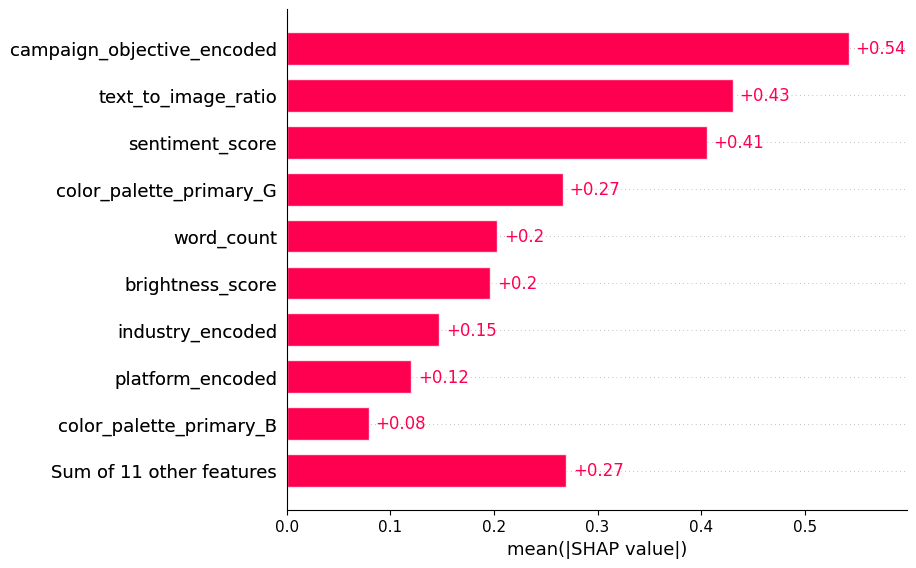

In [86]:
shap.plots.bar(shap_values)

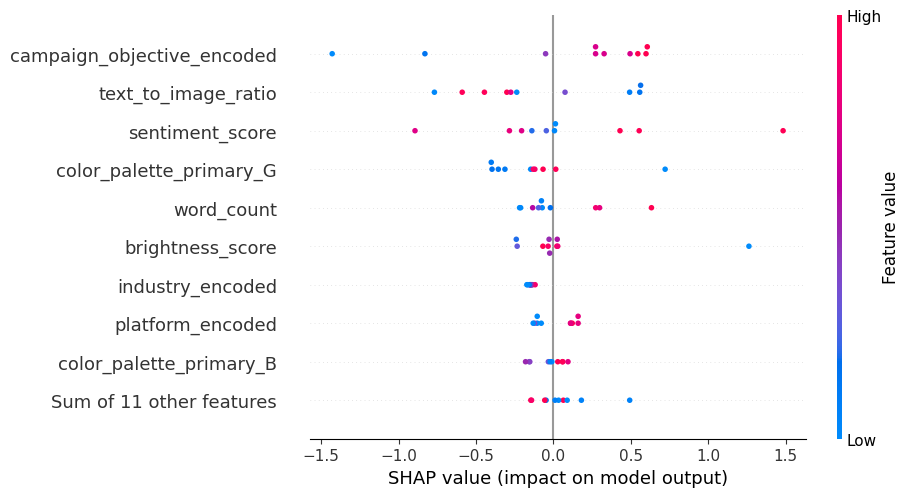

In [87]:
shap.plots.beeswarm(shap_values)

- Higher Campaing Objetives (Lead Generation, Conversion, etc.) lead to higher ROI
- App Install and Awareness ads lead to lower ROI
- Higher sentiment scores lead to higher ROI, and low sentiment does not impact much
- Higher brighness doesn't impact that much
- Higher text_to_image_ratio lead to low ROI, and lower text2image_ratio leads to higher ROI

In [88]:
import joblib

with open ("../models/encoders/label_encoders.pkl", "rb") as f:
    label_encoders = joblib.load(f)

In [89]:
campaign_objective = label_encoders['campaign_objective']
mapping = {class_: idx for idx, class_ in enumerate(campaign_objective.classes_)}
mapping

{'App Install': 0,
 'Awareness': 1,
 'Consideration': 2,
 'Conversion': 3,
 'Lead Generation': 4}

In [90]:
xgb_model.feature_importances_

array([1.9452105e-03, 1.3773161e-02, 2.9010709e-02, 6.0936443e-05,
       4.3902596e-06, 1.8933140e-03, 3.0159442e-02, 5.4118610e-03,
       8.4402859e-03, 1.0122336e-02, 5.0581000e-03, 1.5715429e-01,
       1.1467336e-02, 5.5080289e-01, 5.4683755e-05, 3.7582971e-02,
       1.0568356e-01, 0.0000000e+00, 1.9613719e-05, 3.1354871e-02],
      dtype=float32)

In [91]:
X_train.columns

Index(['duration_seconds', 'brightness_score', 'text_to_image_ratio',
       'logo_size_ratio', 'has_human_face', 'face_count', 'sentiment_score',
       'word_count', 'music_tempo', 'speech_pace', 'color_palette_primary_R',
       'color_palette_primary_G', 'color_palette_primary_B',
       'platform_encoded', 'ad_type_encoded', 'industry_encoded',
       'campaign_objective_encoded', 'target_audience_gender_encoded',
       'aspect_ratio_encoded', 'cta_type_encoded'],
      dtype='object')

In [92]:
import pickle

pickle.dump(xgb_model, open('./xgb_model.pkl', 'wb'))

## Clusterization Atempt

In [93]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
scaler_2 = StandardScaler()
features_scaled = scaler_2.fit_transform(df)

In [95]:
dbscan = DBSCAN(eps=2, min_samples=3)
clusters = dbscan.fit_predict(features_scaled)
df['cluster'] = clusters

In [96]:
df.loc[df['cluster'] == 2]

,duration_seconds,brightness_score,text_to_image_ratio,logo_size_ratio,has_human_face,face_count,sentiment_score,word_count,music_tempo,speech_pace,...,color_palette_primary_G,color_palette_primary_B,platform_encoded,ad_type_encoded,industry_encoded,campaign_objective_encoded,target_audience_gender_encoded,aspect_ratio_encoded,cta_type_encoded,cluster
5,12,65,0.12,0.04,1,1,0.88,8,128.0,0.0,...,200,220,2,3,8,2,1,4,16,2
25,18,74,0.12,0.05,1,1,0.85,10,132.0,0.0,...,200,220,2,3,2,3,1,4,17,2
26,15,70,0.10,0.04,1,1,0.88,8,125.0,0.0,...,190,210,2,3,2,3,1,4,17,2
29,20,68,0.15,0.05,1,2,0.84,14,125.0,0.0,...,175,195,2,3,2,3,1,4,16,2


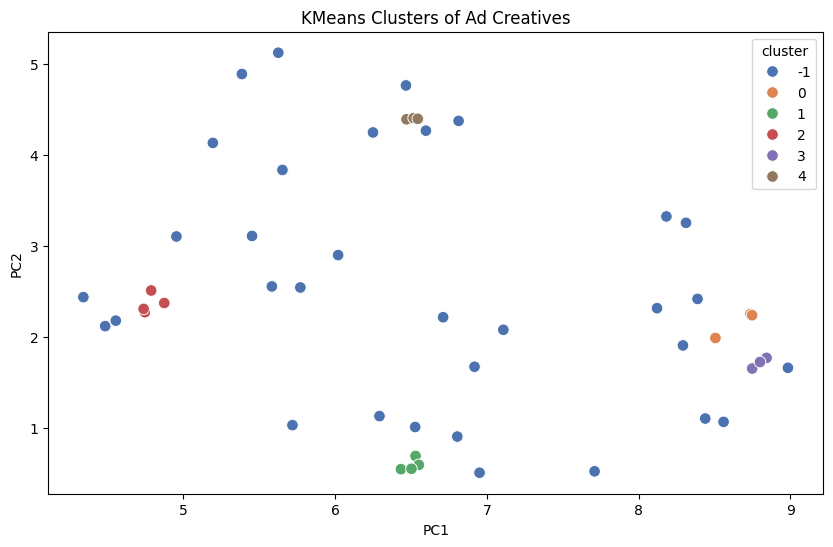

In [97]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features_scaled)

df['PC1'] = tsne_results[:, 0]
df['PC2'] = tsne_results[:, 1]

# Visualizar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', palette='deep', s=70)
plt.title('KMeans Clusters of Ad Creatives')
plt.show()

In [98]:
df.groupby('cluster')['roi'].mean()

cluster
-1    3.484848
 0    2.033333
 1    3.575000
 2    5.050000
 3    3.133333
 4    4.166667
Name: roi, dtype: float64